# Geopandas

[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/davemlz/spyndex/blob/main/docs/tutorials/geopandas.ipynb)
![level5](https://raw.githubusercontent.com/davemlz/spyndex/main/docs/_static/level5.png)

Welcome to the next level: Level 5 - `spyndex + geopandas`!

Remember to install `spyndex`!

> And also remember to install `geopandas`! I recommend you to install it using conda!

In [ ]:
!pip install -U spyndex

Now, let's start!

First, import `spyndex` and `xarray`:

In [56]:
import spyndex
import geopandas as gpd

## `geopandas.GeoDataFrame`

In `geopandas`, each column is a `pandas.Series`. The exception is the `geometry` column, which is a `geopandas.GeoSeries`.

Here we are going to compute spectral indices using `pandas.Series` data types, but adding them to a `geopandas.GeoDataFrame`, making them possible to map!

First, let's create a random sample of reflectances from Sentinel-2. For this, we are going to use `Google Earth Engine`. Let's install some useful packages:

In [ ]:
!pip install eemont geemap

Then, let's import them and initialize `Earth Engine`.

In [57]:
import ee, eemont, geemap

Map = geemap.Map()

Now, let's use the first image in the Sentinel-2 SR collection and sample 1000 random points from it.

> With the `eemont` package we can mask clouds and scale and offset the image!

In [58]:
poi = ee.ImageCollection("COPERNICUS/S2_SR") \
    .first() \
    .maskClouds() \
    .scaleAndOffset() \
    .sample(numPixels = 1000,geometries = True)

Now, let's use `geemap` to convert the samples to a `geopandas.GeoDataFrame`:

In [59]:
gdf = geemap.ee_to_geopandas(poi)

You can see that the `geopandas.GeoDataFrame` has the `geometry` column and the remaining columns are the samples from all bands in the image!

In [60]:
gdf.head()

,geometry,AOT,B1,B11,B12,B2,B3,B4,B5,B6,...,B8A,B9,QA10,QA20,QA60,SCL,TCI_B,TCI_G,TCI_R,WVP
0,POINT (27.29076 26.40036),0.197,0.1070,0.6306,0.5504,0.1367,0.2429,0.3712,0.4120,0.4322,...,0.4331,0.4570,0,0,0,5,139,248,255,0.695
1,POINT (28.06818 26.58967),0.198,0.1697,0.5636,0.4815,0.2111,0.3039,0.3790,0.4122,0.4194,...,0.4274,0.4324,0,0,0,5,215,255,255,0.815
2,POINT (27.87679 26.33568),0.193,0.1670,0.6501,0.5622,0.2118,0.3114,0.4240,0.4666,0.4760,...,0.4990,0.5049,0,0,0,5,216,255,255,0.644
3,POINT (27.04346 26.21331),0.195,0.1363,0.7335,0.6691,0.1859,0.3268,0.4842,0.5332,0.5514,...,0.5692,0.5823,0,0,0,5,189,255,255,0.624
4,POINT (27.53605 26.84894),0.194,0.2098,0.6491,0.5494,0.2606,0.3834,0.5202,0.5680,0.5758,...,0.5684,0.5798,0,0,0,5,255,255,255,0.797


Now, let's check the indices to compute: The `IRECI` and the `NDVI`:

In [61]:
spyndex.indices.IRECI

IRECI: Inverted Red-Edge Chlorophyll Index (attributes = ['bands', 'contributor', 'date_of_addition', 'formula', 'long_name', 'reference', 'short_name', 'type'])

In [62]:
spyndex.indices.NDVI

NDVI: Normalized Difference Vegetation Index (attributes = ['bands', 'contributor', 'date_of_addition', 'formula', 'long_name', 'reference', 'short_name', 'type'])

In [63]:
spyndex.indices.IRECI.bands

('RE3', 'R', 'RE1', 'RE2')

In [64]:
spyndex.indices.NDVI.bands

('N', 'R')

We need the Red Edge bands from Sentinel-2 plus the Red and NIR bands!

Let's make a list of the indices:

In [65]:
indicesToCompute = ["IRECI","NDVI"]

Now, let's compute the indices and add them directly to our `geopandas.GeoDataFrame`:

In [66]:
gdf[indicesToCompute] = spyndex.computeIndex(
    index = indicesToCompute,
    params = {
        "R": gdf["B4"],
        "RE1": gdf["B5"],
        "RE2": gdf["B6"],
        "RE3": gdf["B7"],
        "N": gdf["B8"]
    }
)

You can see that the indices were added as new columns!

In [67]:
gdf.head()

,geometry,AOT,B1,B11,B12,B2,B3,B4,B5,B6,...,QA10,QA20,QA60,SCL,TCI_B,TCI_G,TCI_R,WVP,IRECI,NDVI
0,POINT (27.29076 26.40036),0.197,0.1070,0.6306,0.5504,0.1367,0.2429,0.3712,0.4120,0.4322,...,0,0,0,5,139,248,255,0.695,0.073747,0.097496
1,POINT (28.06818 26.58967),0.198,0.1697,0.5636,0.4815,0.2111,0.3039,0.3790,0.4122,0.4194,...,0,0,0,5,215,255,255,0.815,0.045786,0.070281
2,POINT (27.87679 26.33568),0.193,0.1670,0.6501,0.5622,0.2118,0.3114,0.4240,0.4666,0.4760,...,0,0,0,5,216,255,255,0.644,0.066105,0.091688
3,POINT (27.04346 26.21331),0.195,0.1363,0.7335,0.6691,0.1859,0.3268,0.4842,0.5332,0.5514,...,0,0,0,5,189,255,255,0.624,0.085109,0.097904
4,POINT (27.53605 26.84894),0.194,0.2098,0.6491,0.5494,0.2606,0.3834,0.5202,0.5680,0.5758,...,0,0,0,5,255,255,255,0.797,0.061128,0.060926


Finally, let's map the indices!

In [68]:
import matplotlib.pyplot as plt

You'll see a lot of low values for both indices, that's because that image is in the desert with some pivot crops!

[Text(0.5, 1.0, 'NDVI')]

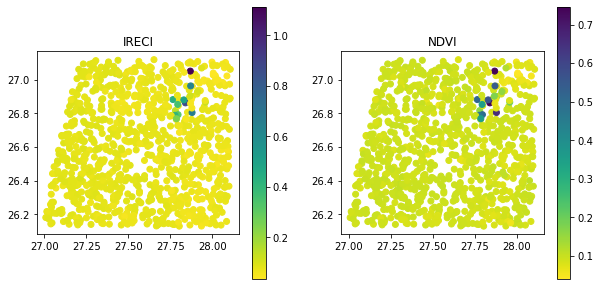

In [69]:
fig, ax = plt.subplots(1, 2,figsize = (10,5))

gdf.plot(column = 'IRECI',legend = True,ax = ax[0],cmap = "viridis_r")
ax[0].set(title = "IRECI")

gdf.plot(column = 'NDVI',legend = True,ax = ax[1],cmap = "viridis_r")
ax[1].set(title = "NDVI")

That's all for now! :) See you in a next tutorial!